In [16]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as sk
import time

import warnings
warnings.filterwarnings('ignore')

In [17]:
def display_clusters(clusters):
    colors = plt.get_cmap('Accent')(np.linspace(0, 1, len(clusters)))
    for (cluster_center, cluster), color in zip(clusters.items(), colors):
        plt.scatter(*zip(*cluster), s=10, color=color)
    plt.show()
    
class KMeans:
    converged = False
    clusters = set()
    clusters_i = set()
    
    def compute_clusters(self, X, cluster_centers):
        dataset, cluster_centers = np.array(X), np.array(cluster_centers)

        diff = X - np.repeat(cluster_centers[:,np.newaxis,:], len(X), axis=1)
        norms = np.linalg.norm(diff,axis=2)    
        mins = cluster_centers[np.argmin(norms,axis=0)]

        clusters = {}
        clusters_i = {}

        for center in cluster_centers:
            clusters[tuple(center)] = set()
            clusters_i[tuple(center)] = []

        i = 0
        for x, cc in zip(X, mins):
            clusters[tuple(cc)].add(tuple(x))
            clusters_i[tuple(cc)].append(i)
            i += 1

        return clusters, clusters_i
        
    def __init__(self, dataset, num_clusters, max_iter = 300):
        np.random.seed(int(time.time()))
        cc = np.array(dataset)[np.random.choice(len(dataset), size=num_clusters, replace=False)]
#         cc = [np.array(dataset)[0], np.array(dataset)[1], np.array(dataset)[2]]
        self.clusters, self.clusters_i = self.compute_clusters(dataset, cc)
        
        for i in range(max_iter):
            cc = [np.mean(list(cluster), axis=0) for cluster in self.clusters.values()]
            
            new_clusters, self.clusters_i = self.compute_clusters(dataset, cc)
            
            if new_clusters == self.clusters:
                self.converged = True
                break
                
            self.clusters = new_clusters

In [18]:
class SpectralClustering:    
    def __init__(self, data, n_clusters, n_neighbors):
        self.data = data
        self.n_clusters = n_clusters
        self.n_neighbors = n_neighbors
        
    def get_distance_matrix(self):
        diff_squared = (self.data[:, np.newaxis, :] - self.data[np.newaxis, :, :]) ** 2
        squared_distances = diff_squared.sum(axis=2)
        distance_matrix = np.sqrt(squared_distances)
        return distance_matrix
        
    def get_k_nearest(self):
        distance_matrix = self.get_distance_matrix()
        k_nearest = np.zeros_like(distance_matrix)
        k = self.n_neighbors
        
        for i in range(distance_matrix.shape[0]):
            closest_indices = np.argpartition(distance_matrix[i], k+1)[:k+1]
            closest_indices = closest_indices[closest_indices != i][:k]

            for j in closest_indices:                
                k_nearest[i, j] = 1
        
        return k_nearest
    
    def get_degree_matrix(self, sim):
        degrees = np.zeros_like(sim)
        
        for i in range(sim.shape[0]):
            degrees[i,i] = np.count_nonzero(sim[i,:])
            
        return degrees
    
    def get_laplacian_matrix(self):
        sim = self.get_k_nearest()
        
        degree_matrix = self.get_degree_matrix(sim)

        laplacian = degree_matrix - sim
        return laplacian
    
    def get_u(self):
        k = self.n_neighbors
        laplacian = self.get_laplacian_matrix()
        
        eigenvalues, eigenvectors = np.linalg.eig(laplacian)
    
        idx = eigenvalues.argsort()
        sorted_eigenvectors = eigenvectors[:, idx]

        u = sorted_eigenvectors[:, :k]
    
        return u
        
    
    def run_k_means(self):
        u = self.get_u()

        kmeans = KMeans(u, self.n_clusters)
        
        clusters = kmeans.clusters_i
        
        for i, cc in enumerate(list(clusters.keys())):
            new_points = []
            for idx in clusters[cc]:
                new_points.append(data[idx])
            clusters[cc] = np.array(new_points)

        return clusters
               

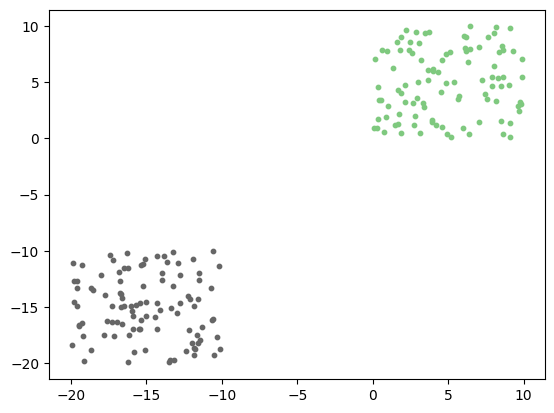

In [264]:
# Very Simple Exampe
num_points_in_each_cluster = 100
point_dim = 2
a = (np.random.rand(num_points_in_each_cluster, point_dim) * 10) - 20
b = (np.random.rand(num_points_in_each_cluster, point_dim) * 10) + 0
test_data = np.concatenate((a, b), axis=0)



data = test_data
sc = SpectralClustering(data, 2, 4)
clusters = sc.run_k_means()


display_clusters(clusters)

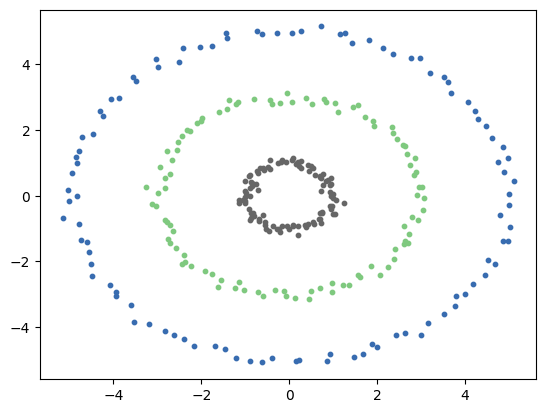

In [266]:
# Example from class where KMeans failed
circle = lambda x, y, stddev, radius, n_samples: [
    (
        x + radius * math.cos(2 * math.pi * i / n_samples) + np.random.normal(0, stddev),
        y + radius * math.sin(2 * math.pi * i / n_samples) + np.random.normal(0, stddev)
    )
    for i in range(n_samples)
]

circles_dataset = sum((circle(0, 0, 0.1, radius, 100) for radius in [1, 3, 5]), start=[])

data = np.array(circles_dataset)

sc = SpectralClustering(data, 3, 4)
clusters = sc.run_k_means()


display_clusters(clusters)

In [20]:
"""
Benchmark Compared to SKLearn
"""
import time
from sklearn.cluster import SpectralClustering as SkSpectralClustering


num_times_to_run = 100

start_time = time.time()
for _ in range(num_times_to_run):
    sc = SpectralClustering(data, 3, 4)
    clusters = sc.run_k_means()
    
end_time = time.time()
our_duration = (end_time - start_time) / num_times_to_run

print(f"Our implementation took {round(our_duration, 4)} seconds per KMeans cluster fit")

X = np.array([list(t) for t in data])
start_time = time.time()
for _ in range(num_times_to_run):
    spectral = SkSpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=4)
    spectral.fit(X)

end_time = time.time()
their_duration = (end_time - start_time) / num_times_to_run

print(f"SKLearn implementation took {round(their_duration, 4)} seconds per KMeans cluster fit")
print(f"Thus, the SKLearn implementation is {round((our_duration)/their_duration, 4)}x faster than ours")

Our implementation took 0.0797 seconds per KMeans cluster fit
SKLearn implementation took 0.0426 seconds per KMeans cluster fit
Thus, the SKLearn implementation is 1.8719x faster than ours
